In [1]:
import numpy as np
import pandas as pd
import mne
from mne_bids import BIDSPath, read_raw_bids
import matplotlib.pyplot as plt
from pathlib import Path
from mne.preprocessing import ICA
from mne.preprocessing import create_eog_epochs, create_ecg_epochs
from mne import make_fixed_length_epochs
from scipy.signal import welch
# from mne.connectivity import phase_lag_index

## Load and visualize:

In [2]:
# Set the path to the BIDS dataset
bids_root = "/Users/amralaa/Desktop/Research Files/eeg_roman/TD_BRAIN_SAMPLE"

In [3]:
participants = pd.read_csv(bids_root + '/participants.tsv', sep = '\t')

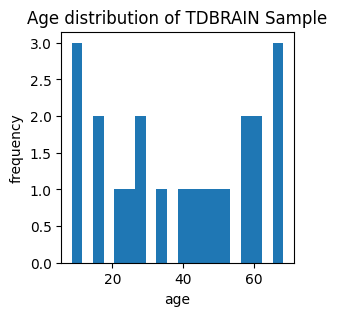

In [4]:
plt.figure(figsize=(3,3));
participants.age.plot(kind='hist', bins=20);
plt.xlabel('age');
plt.ylabel('frequency');
plt.title('Age distribution of TDBRAIN Sample');

In [5]:
# for mne, set the global log level to 'WARNING' or higher to suppress informational messages:
mne.set_log_level('WARNING')

In [6]:
def get_cortical_regions(raw):
    """
    Define cortical regions based on electrode names.
    
    Parameters:
        raw: MNE raw object
    
    Returns:
        channel_regions (dict): mapping from channel names to cortical regions
    """
    # this excludes "unknown" channels in the EEG (see channels info tsv files)
    frontal_channels = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8']
    central_channels = ['FC5', 'FC1', 'FC2', 'FC6', 'C3', 'Cz', 'C4', 'CP5', 'CP1', 'CP2', 'CP6']
    temporal_channels = ['T7', 'T8', 'FT9', 'FT10']
    parietal_channels = ['P7', 'P3', 'Pz', 'P4', 'P8']
    occipital_channels = ['O1', 'Oz', 'O2']
    
    # Create a mapping from channel names to cortical regions
    channel_regions = {}
    for channel in raw.ch_names:
        if channel in frontal_channels:
            channel_regions[channel] = 'F'
        elif channel in central_channels:
            channel_regions[channel] = 'C'
        elif channel in temporal_channels:
            channel_regions[channel] = 'T'
        elif channel in parietal_channels:
            channel_regions[channel] = 'P'
        elif channel in occipital_channels:
            channel_regions[channel] = 'O'
    return channel_regions

In [7]:
# we'll work with many of these nested lists and np arrays. Let's create a func to print their dims
def nested_shape(obj):
    """
    Prints the shape of the first encountered nested list and numpy array in one line, comma-separated.
    
    Parameters:
        obj: nested list or numpy array
    
    Returns:
        None
    """
    if isinstance(obj, list):
        print(len(obj), end=", ")
        if obj:
            nested_shape(obj[0])
    elif isinstance(obj, np.ndarray):
        print(obj.shape, end=" ")
    else:
        print("", end="")

## Cleaning the data:

Since our dataset ir organized according to the Brain Imaging Data Structure (BIDS) standard, 
we'll use MNE-BIDS which is a Python package that is designed to facilitate the handling, analysis, 
and storage of electrophysiological data (EEG, MEG, iEEG, etc.) in the BIDS format. 
- **Steps in cleaning include:**
  1. **Removing baseline noise** and applying a filter to keep only the brainwave frequencies of interest.
  2. **Deleting faulty electrodes** due to noise or bad contact and removing unnecessary reference data.
  3. **Using ICA (Independent Component Analysis)** to get rid of eye movement artifacts and other noise, repeated if necessary.
  4. **Averaging the data** re-referencing the EEG data to an average reference and segmenting the continuous EEG data into overlapping windows.

In [8]:
# Initialize lists to store data and labels
eeg_data_EO = []
eeg_data_EC = []
ages = []
channel_regions = None

# Define your filter parameters
l_freq = 0.3  # high-pass filter cutoff (lower edge)
h_freq = 54  # low-pass filter cutoff (upper edge)
method = 'iir'  # Filter method
iir_params = dict(order=2, ftype='butter')  # Butterworth filter parameters

# 'bad_channels' is a list of channel names that are noisy or show bad contact
# we want to remove 'Fz' as well, so we include it in the list
bad_channels = ['Fz']  # Update this list based on your data analysis

# Define your ICA parameters
n_components = 15  # Number of components to keep. Adjust based on your data.
method = 'fastica'  # FastICA algorithm

# Loop through each participant and session
for _, participant in participants.iterrows():
    participant_id = participant['participant_id'].replace('sub-', '')  # Ensure the 'sub-' prefix is removed
    age = participant['age']
    
    # Define the BIDS path for the Eyes Open condition, and similarly for Eyes Closed
    bids_path_EO = BIDSPath(subject=participant_id, session='1', task='restEO', datatype='eeg', 
                            suffix='eeg', root=bids_root)
    bids_path_EC = BIDSPath(subject=participant_id, session='1', task='restEC', datatype='eeg', 
                            suffix='eeg', root=bids_root)
    
    # Process Eyes Open condition
    raw_EO = read_raw_bids(bids_path=bids_path_EO)
    raw_EO.load_data()
    # Mark bad channels
    raw_EO.info['bads'] += bad_channels  # This adds your predefined bad channels to the list
    # Filter the data
    raw_EO.filter(l_freq=0.3, h_freq=54, method='iir', iir_params=dict(order=2, ftype='butter'), verbose=False)
    # Fit ICA
    ica = ICA(n_components=n_components, method=method)
    ica.fit(raw_EO)
    # Apply ICA to the Raw object to remove the components
    ica.apply(raw_EO)

    # Pick good EEG channels, excluding bad ones and the 'Fz' reference
    raw_EO.pick_types(eeg=True, exclude='bads')
    
    channel_regions = get_cortical_regions(raw_EO) # after Fz removed

    raw_EO.set_eeg_reference('average', projection=True) # Re-reference to the average
    raw_EO.apply_proj()

    # Segment data into 2-second windows with 1-second overlap
    # This creates epochs from the continuous data
    epochs_EO = make_fixed_length_epochs(raw_EO, duration=2.0, overlap=1.0, verbose=False)
    
    # Here you might want to operate on epochs_EO or convert it to data arrays
    # For example, you can access the data for each epoch as a 3D array
    data_EO = epochs_EO.get_data()
    eeg_data_EO.append(data_EO)

    # Process Eyes Closed condition similarly
    raw_EC = read_raw_bids(bids_path=bids_path_EC)
    raw_EC.load_data()
    raw_EC.info['bads'] += bad_channels
    raw_EC.filter(l_freq=0.3, h_freq=54, method='iir', iir_params=dict(order=2, ftype='butter'), verbose=False)
    ica = ICA(n_components=n_components, method=method) 
    ica.fit(raw_EC)
    ica.apply(raw_EC)

    raw_EC.pick_types(eeg=True, exclude='bads')
    raw_EC.set_eeg_reference('average', projection=True)
    raw_EC.apply_proj()

    epochs_EC = make_fixed_length_epochs(raw_EC, duration=2.0, overlap=1.0, verbose=False)
    data_EC = epochs_EC.get_data()
    eeg_data_EC.append(data_EC)

    # Append age
    ages.append(age)

In [9]:
nested_shape(eeg_data_EO), nested_shape(eeg_data_EC)
# 22 subjects (epochs, channels, timepoints)

22, (119, 32, 1000) 22, (119, 32, 1000) 

(None, None)

## Feature Extraction:

Calculate the power spectral density (PSD) for each epoch and each cortical region using Welch's periodogram method. We also calculate relative power for each frequency band, as well as the dominant frequency (DF) and dominant frequency variance (DFV).

In [10]:
from scipy.signal import welch

freqs = None # to use later

# EEG data has a length of 1000 samples
data_length = 1000

# Set nperseg to a value less than or equal to the data length
nperseg = 512 # how many pieces to cut EEG into

# for each piece, we analyze what frequencies are present and how strong each one is -> freqs in final output

# Set noverlap to a value less than nperseg
noverlap = nperseg // 2  # 50% overlap - when we cut, we make overlaps 

# Calculate PSD for each epoch and cortical region
psd_data = []
for eeg in eeg_data_EO + eeg_data_EC:  # Combine Eyes Open and Eyes Closed data
    psd_epoch = []
    for region in ['F', 'C', 'T', 'P', 'O']:
        region_channels = [ch for ch, reg in channel_regions.items() if reg == region]
        region_data = eeg[:, np.array([raw_EO.ch_names.index(ch) for ch in region_channels])]
        freqs, psd = welch(region_data, fs=raw_EO.info['sfreq'], nperseg=nperseg, noverlap=noverlap, nfft=None)
        # print(len(freqs), psd.shape)
        psd_epoch.append(psd)
    psd_data.append(psd_epoch)


# - In the end, the algorithm gives you two important pieces of information:
#  - `freqs`: A list of frequencies that it checked (at which frequencies it looked to analyze the EEG data).
#  - `psd`: For each frequency in `freqs`, how much power there is.
#  This shows how much of each "frequency" is present in the brain's electrical activity.

In [11]:
nested_shape(psd_data)
# subjects , 5 cortical regions, (epochs, channels, freq_bins)

44, 5, (119, 6, 257) 

The output from applying the Welch algorithm to EEG data across various cortical regions and conditions results in a frequency vector (`freqs`) and corresponding PSD values with dimensions detailed as follows:

- The `freqs` array contains 257 discrete frequency bins, indicating PSD calculations were made for 257 different frequencies based on the `nperseg` parameter and the EEG data's sampling frequency.
- The `psd.shape` provides dimensions as `(119, X, 257)`, where `119` represents the number of epochs, `X` is the variable number of channels in each cortical region, and `257` is the number of frequency bins.
- Different cortical regions have varying numbers of channels (`X`), reflected in the PSD matrix's shape, such as `(119, 6, 257)`, `(119, 3, 257)`, `(119, 2, 257)`, and `(119, 5, 257)`, indicating the analysis depth for each region.

In [12]:
# first: Average or sum the PSD data across the channels and conditions (EO, EC) for the region. 
# The result should be a structure like the original psd_data but without the channel dimension, 
# ie: 2D array for each subject and cortical region, averaged across channels.

averaged_psd_data = []

for subject in psd_data: #iterate over 44 (22 x 2 subjects)
    subjects_averages = []
    for region_array in subject: # each has 5 cortical regions , each holds a 3d array (epochs, n_channels, freq_bins)
        # Average across the channel dimension (axis=1)
        regions_average = np.mean(region_array, axis=1) # now has shape: (epochs, freq_bins)
        subjects_averages.append(regions_average)
    averaged_psd_data.append(subjects_averages)
    

In [13]:
nested_shape(averaged_psd_data)

44, 5, (119, 257) 

In [14]:
# Calculate Absolute Power for Bands: For each subject, condition, and region, 
# Calculate the absolute power within each frequency band by integrating the PSD over the band's frequency range.

# identify the indices of the frequency bins that correspond to each band's range
# then sum the PSD values across those indices


# Define frequency bands
bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 5.5),
    'High Theta': (5.5, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
}


# The resulting structure should mirror the structure of `averaged_psd_data`
# but with an added dimension for bands
absolute_power_data = []

# Loop through each subject's data
for subject_data in averaged_psd_data:
    subject_power = []
    for region_array in subject_data: # region_array has shape: (epochs, freq_bins) -> (119, 257)
        region_power = []
        for band_name, (low_freq, high_freq) in bands.items(): # for each band
            # Find indices of freqs that fall within the current band
            band_indices = np.where((freqs >= low_freq) & (freqs <= high_freq))[0]
            # Sum the PSD values across these indices to get absolute power
            band_power = np.sum(region_array[:, band_indices], axis=1)
            # band_power now has the shape: (epochs,)
            
            region_power.append(band_power)
        subject_power.append(region_power)
    absolute_power_data.append(subject_power)

# absolute_power_data now contains the absolute power for each band
# Structured as (subjects, cortical_regions, bands, epochs)

In [15]:
nested_shape(absolute_power_data)

44, 5, 5, (119,) 

In [16]:
relative_power_data = []

# Iterate over subjects, regions, and epochs to calculate relative power
for subject_data in absolute_power_data:
    subject_relative_power = []
    for region_data in subject_data:
        # Calculate total power across all bands for each epoch
        total_power = np.sum(region_data, axis=0)
        
        # Calculate relative power for each band
        region_relative_power = region_data / total_power
        subject_relative_power.append(region_relative_power)
    relative_power_data.append(subject_relative_power)

# relative_power_data now structured as (subjects, cortical_regions, bands, epochs), with relative power values

In [17]:
nested_shape(relative_power_data)

44, 5, (5, 119) 

In [18]:
# Initialize a structure for dominant frequency data
dominant_frequency_data = []

# Iterate over the averaged PSD data to find the dominant frequency for each epoch
for subject_data in averaged_psd_data:
    subject_df = []
    for region_data in subject_data:
        # Find the index of the max power frequency bin for each epoch
        df_indices = np.argmax(region_data, axis=1)
        # Retrieve the actual frequencies using these indices
        df_frequencies = freqs[df_indices]
        subject_df.append(df_frequencies)
    dominant_frequency_data.append(subject_df)

# dominant_frequency_data structured as (subjects, cortical_regions, epochs), containing DF frequencies

In [19]:
nested_shape(dominant_frequency_data)

44, 5, (119,) 

In [20]:
# DFV for each cortical region
dfv_by_region_data = []

# Iterate over the dominant frequency data to calculate variance for each region
for subject_df in dominant_frequency_data:
    subject_dfv = []
    for region_df in subject_df:
        # Calculate variance of DF frequencies for the current region
        dfv = np.var(region_df)
        subject_dfv.append(dfv)
    dfv_by_region_data.append(subject_dfv)

# dfv_by_region_data structured as (subjects, cortical_regions), containing DFV for each region

In [21]:
nested_shape(dfv_by_region_data)

44, 5, 

## Prepare Feature Matrix:

Create a feature matrix where each row represents a subject, and each column represents a feature derived from the PSD data across different cortical regions, conditions (EO/EC), and channels. We will include the subject's age as a target variable for prediction

In [22]:
feature_matrix = []

# Number of subjects (assuming 22 subjects with EO and EC conditions)
num_subjects = 22

for i in range(num_subjects):
    # Initialize a list to hold features for this subject
    subject_features = []
    
    # For each condition (EO, EC) and each type of data
    for condition_index in [i, i + num_subjects]:  # Index for EO and EC
        # Aggregate and append features for relative power, DF, etc.
        
        # For relative power data (mean across epochs)
        mean_rel_power_eo_ec = np.mean(relative_power_data[condition_index], axis=2)  # Averaging across epochs
        subject_features.extend(mean_rel_power_eo_ec.flatten().tolist())
        
        # Append average DF across epochs
        mean_df = np.mean(dominant_frequency_data[condition_index], axis=1)
        subject_features.extend(mean_df.tolist())
        
        # DFV data can be directly appended since it's already per subject per region
        subject_features.extend(dfv_by_region_data[condition_index])
    
    # Add this subject's features to the feature matrix
    feature_matrix.append(subject_features)

# Convert the feature matrix to a NumPy array
feature_matrix_np = np.array(feature_matrix)
feature_matrix_np.shape

(22, 70)

In [23]:
# convert to dataframe:
# subject_ids = [participants.participant_id.to_list()][0]

# feature names creation
conditions = ['EO', 'EC']
regions = ['F', 'C', 'T', 'P', 'O']
bands = ['Delta', 'Theta', 'High', 'Alpha', 'Beta']
metrics = ['RelPower', 'DF', 'DFV']

# Constructing feature names
feature_names = []
for condition in conditions:
    for region in regions:
        for band in bands:
            feature_names.append(f"{band}_RelPower_{region}_{condition}")
        feature_names.append(f"DF_{region}_{condition}")
        feature_names.append(f"DFV_{region}_{condition}")

df = pd.DataFrame(feature_matrix_np, columns=feature_names)
df.head()

,Delta_RelPower_F_EO,Theta_RelPower_F_EO,High_RelPower_F_EO,Alpha_RelPower_F_EO,Beta_RelPower_F_EO,DF_F_EO,DFV_F_EO,Delta_RelPower_C_EO,Theta_RelPower_C_EO,High_RelPower_C_EO,...,Beta_RelPower_P_EC,DF_P_EC,DFV_P_EC,Delta_RelPower_O_EC,Theta_RelPower_O_EC,High_RelPower_O_EC,Alpha_RelPower_O_EC,Beta_RelPower_O_EC,DF_O_EC,DFV_O_EC
0,0.573986,0.028163,0.069962,0.081298,0.246590,0.442476,0.051404,0.128176,0.124739,0.253205,...,1.050420,5.514706,3.914456,8.493632,8.986016,0.643685,25.013326,18.712786,13.616780,9.337671
1,0.662748,0.031119,0.082243,0.104022,0.119867,0.447780,0.035681,0.097435,0.141889,0.277215,...,1.034007,3.290769,1.624869,3.873424,4.759716,0.068827,20.561948,5.229618,15.658415,18.200828
2,0.662748,0.031119,0.082243,0.104022,0.119867,0.447780,0.035681,0.097435,0.141889,0.277215,...,1.034007,3.290769,1.624869,3.873424,4.759716,0.068827,20.561948,5.229618,15.658415,18.200828
3,0.662748,0.031119,0.082243,0.104022,0.119867,0.447780,0.035681,0.097435,0.141889,0.277215,...,1.034007,3.290769,1.624869,3.873424,4.759716,0.068827,20.561948,5.229618,15.658415,18.200828
4,0.685961,0.064301,0.130997,0.069745,0.048996,0.242728,0.039572,0.201481,0.297572,0.218647,...,6.835938,8.649554,8.296678,9.002429,9.281447,11.379979,2.504969,1.456540,0.836022,0.446768


In [24]:
df.to_csv('feature_matrix.csv', index=False)

In [26]:
ages_df = pd.DataFrame(ages)
ages_df.to_csv('ages.csv', index=False)